# Projeto ETL SuperStore

Este notebook contém o processo de ETL (Extração, Transformação e Carga) para o conjunto de dados SuperStore. Utilizaremos diversas bibliotecas para manipulação de dados e, posteriormente, carregaremos os dados no BigQuery.

## 1. Configuração do Ambiente e Importação de Bibliotecas

Importação de todas as bibliotecas necessárias

In [16]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import re
import os
import requests
from pathlib import Path
import requests
from bs4 import BeautifulSoup, NavigableString, Tag
from urllib.parse import urljoin
from datetime import date, timedelta
from io import StringIO
from typing import Optional
from google.cloud import bigquery



print("✅ Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


## 2. Carregamento dos Dados e Inicialização do DataFrame

Agora vamos carregar o conjunto de dados SuperStore do arquivo CSV e realizar uma inspeção inicial dos dados.

In [17]:
# Carregar o dataset
df = pd.read_csv("../data/raw/superstore.csv")  # AJUSTE O CAMINHO

print(f"\n📊 Formato da base: {df.shape}")
print(f"📊 Colunas: {df.columns.tolist()}")

df.head()


📊 Formato da base: (51290, 27)
📊 Colunas: ['category', 'city', 'country', 'customer_ID', 'customer_name', 'discount', 'market', 'unknown', 'order_date', 'order_id', 'order_priority', 'product_id', 'product_name', 'profit', 'quantity', 'region', 'row_id', 'sales', 'segment', 'ship_date', 'ship_mode', 'shipping_cost', 'state', 'sub_category', 'year', 'market2', 'weeknum']


,category,city,country,customer_ID,customer_name,discount,market,unknown,order_date,order_id,...,sales,segment,ship_date,ship_mode,shipping_cost,state,sub_category,year,market2,weeknum
0,Office Supplies,Los Angeles,United States,LS-172304,Lycoris Saunders,0.0,US,1,2011-01-07 0:00:00,CA-2011-130813,...,19,Consumer,2011-01-09 0:00:00,Second Class,4.37,California,Paper,2011,North America,2
1,Office Supplies,Los Angeles,United States,MV-174854,Mark Van Huff,0.0,US,1,2011-01-21 0:00:00,CA-2011-148614,...,19,Consumer,2011-01-26 0:00:00,Standard Class,0.94,California,Paper,2011,North America,4
2,Office Supplies,Los Angeles,United States,CS-121304,Chad Sievert,0.0,US,1,2011-08-05 0:00:00,CA-2011-118962,...,21,Consumer,2011-08-09 0:00:00,Standard Class,1.81,California,Paper,2011,North America,32
3,Office Supplies,Los Angeles,United States,CS-121304,Chad Sievert,0.0,US,1,2011-08-05 0:00:00,CA-2011-118962,...,111,Consumer,2011-08-09 0:00:00,Standard Class,4.59,California,Paper,2011,North America,32
4,Office Supplies,Los Angeles,United States,AP-109154,Arthur Prichep,0.0,US,1,2011-09-29 0:00:00,CA-2011-146969,...,6,Consumer,2011-10-03 0:00:00,Standard Class,1.32,California,Paper,2011,North America,40


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   category        51290 non-null  object 
 1   city            51290 non-null  object 
 2   country         51290 non-null  object 
 3   customer_ID     51290 non-null  object 
 4   customer_name   51290 non-null  object 
 5   discount        51290 non-null  float64
 6   market          51290 non-null  object 
 7   unknown         51290 non-null  int64  
 8   order_date      51290 non-null  object 
 9   order_id        51290 non-null  object 
 10  order_priority  51290 non-null  object 
 11  product_id      51290 non-null  object 
 12  product_name    51290 non-null  object 
 13  profit          51290 non-null  float64
 14  quantity        51290 non-null  int64  
 15  region          51290 non-null  object 
 16  row_id          51290 non-null  int64  
 17  sales           51290 non-null 

## 3. Tratamento de Valores Nulos

In [19]:
print("🔍 Valores nulos por coluna:\n")
print(df.isnull().sum().sort_values(ascending=False))

🔍 Valores nulos por coluna:

category          0
city              0
country           0
customer_ID       0
customer_name     0
discount          0
market            0
unknown           0
order_date        0
order_id          0
order_priority    0
product_id        0
product_name      0
profit            0
quantity          0
region            0
row_id            0
sales             0
segment           0
ship_date         0
ship_mode         0
shipping_cost     0
state             0
sub_category      0
year              0
market2           0
weeknum           0
dtype: int64


## 4. Tratamento de Valores Duplicados

In [20]:
duplicated_values = df[df.duplicated()]
print(f"Valores duplicados: {len(duplicated_values)}")

Valores duplicados: 0


In [21]:
df['row_id'].duplicated().sum()

np.int64(0)

## 5. Tratamento de Variáveis Categóricas

In [22]:
# nomes de colunas padronizados
cols_to_standardize = [
    'ship_mode', 'segment', 'category', 'sub_category',
    'market', 'market2', 'order_priority'
]

for col in cols_to_standardize:
    if col in df.columns:
        df[col] = df[col].astype('string').str.strip().str.lower()

print("✅ Variáveis categóricas padronizadas (lowercase e strip) para consistência.")

✅ Variáveis categóricas padronizadas (lowercase e strip) para consistência.


## 6. Tratamento de Variáveis Numéricas

In [23]:
num_cols = df.select_dtypes(include=['int64', 'float64', 'Int64']).columns
print(f"📊 Colunas numéricas detectadas: {len(num_cols)}")
print(num_cols.tolist())

📊 Colunas numéricas detectadas: 9
['discount', 'unknown', 'profit', 'quantity', 'row_id', 'sales', 'shipping_cost', 'year', 'weeknum']


In [24]:
# 1) Checar se há strings perdidas em colunas que deveriam ser numéricas
for col in num_cols:
    count_text = df[col].apply(lambda x: isinstance(x, str)).sum()
    if count_text > 0:
        print(f"⚠️  Coluna '{col}' contém {count_text} valores de TEXTO.")

# 2) Regras simples de faixa 
sanity_checks = {}

if 'discount' in df.columns:
    bad = df[(df['discount'] < 0) | (df['discount'] > 1)]
    sanity_checks['discount_fora_[0,1]'] = len(bad)

if 'quantity' in df.columns:
    bad = df[df['quantity'] <= 0]
    sanity_checks['quantity_<=0'] = len(bad)

if 'sales' in df.columns:
    bad = df[df['sales'] < 0]
    sanity_checks['sales_negativas'] = len(bad)

if 'profit' in df.columns:
    # ajuste o limite se quiser; aqui é só um “sinalizador” de valores muito fora
    bad = df[df['profit'] < -10000]
    sanity_checks['profit_muito_negativo(<-10000)'] = len(bad)

if sanity_checks:
    print("\n🧪 Sanidade básica:")
    for k, v in sanity_checks.items():
        print(f" - {k}: {v} registros")


🧪 Sanidade básica:
 - discount_fora_[0,1]: 0 registros
 - quantity_<=0: 0 registros
 - sales_negativas: 0 registros
 - profit_muito_negativo(<-10000): 0 registros


In [25]:
# 3) Outliers pelo método IQR (Q1–1.5*IQR, Q3+1.5*IQR)
outliers_dict = {}

for col in num_cols:
    series = df[col].dropna()
    if series.empty:
        outliers_dict[col] = 0
        print(f"{col}: 0 outliers identificados. (coluna vazia)")
        continue

    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower, upper = (q1 - 1.5 * iqr, q3 + 1.5 * iqr)

    outliers = df[(df[col].notna()) & ((df[col] < lower) | (df[col] > upper))]
    outliers_dict[col] = len(outliers)

# 4) Nulos por variável numérica (para compor o relatório)
null_values = (
    df[num_cols]
    .isna()
    .sum()
    .reset_index()
    .rename(columns={'index': 'Variável', 0: 'Qtd_Nulos'})
)

# 5) Tabela de outliers para juntar no relatório
outliers_df = pd.DataFrame(list(outliers_dict.items()),
                           columns=['Variável', 'Qtd_Outliers'])

# 6) Relatório final (Nulos + Outliers) — mesmo estilo do seu exemplo
variable_report = null_values.merge(outliers_df, on='Variável', how='outer')
variable_report = variable_report[(variable_report['Qtd_Nulos'] > 0) |
                                  (variable_report['Qtd_Outliers'] > 0)]
variable_report = variable_report.fillna(0)
variable_report['Qtd_Nulos'] = variable_report['Qtd_Nulos'].astype(int)
variable_report['Qtd_Outliers'] = variable_report['Qtd_Outliers'].astype(int)

print("\n📑 Relatório (somente variáveis com nulos ou outliers):")
display(variable_report.sort_values(['Qtd_Outliers', 'Qtd_Nulos'], ascending=False))


📑 Relatório (somente variáveis com nulos ou outliers):


,Variável,Qtd_Nulos,Qtd_Outliers
1,profit,0,9755
5,shipping_cost,0,5909
4,sales,0,5655
0,discount,0,4172
2,quantity,0,877


## 8. Pesquisar dados de outras fontes

**Objetivo:** Fazer web scraping para incluir os concorrentes da Super Store.

De acordo com o requisito, o objetivo é extrair a tabela de empresas **multinacionais** da Wikipédia para incluir os concorrentes da Super Store na estrutura de dados.

In [26]:
url = "https://en.wikipedia.org/wiki/List_of_supermarket_chains"

# Adiciona cabeçalho simulando navegador (User-Agent)
headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/118.0.0.0 Safari/537.36"
    ),
    "Accept-Language": "en-US,en;q=0.9",
}

if resp.status_code == 200:
    print("✅ Página carregada com sucesso!")
    soup = BeautifulSoup(resp.text, "html.parser")
    table = soup.find('table', {'class': 'wikitable sortable'})
    df_competitors = pd.read_html(str(table))[0]
    print(f"✅ DataFrame de concorrentes extraído com sucesso. Formato: {df_competitors.shape}")
    display(df_competitors.head())
else:
    print(f"❌ Falha ao acessar a página. Código: {resp.status_code}")

✅ Página carregada com sucesso!
✅ DataFrame de concorrentes extraído com sucesso. Formato: (371, 6)


C:\Users\Notebook\AppData\Local\Temp\ipykernel_11076\2965521675.py:17: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_competitors = pd.read_html(str(table))[0]


,Company,Headquarters,Served countries (besides the headquarters),Map,Number of locations,Number of employees
0,7-Eleven,Japan United States,"Australia, Canada, China, Cambodia, Denmark, H...",NaN,85000,170000
1,Aeon,Japan,"Australia, Cambodia, China, Hong Kong, India, ...",NaN,20008,"560,000+"
2,Ahold Delhaize,Netherlands,"Belgium (as Albert Heijn and Delhaize), Czech ...",NaN,7659,375000
3,Aldi,Germany (Süd and Nord),"Australia (Süd), Austria (Süd as Hofer), China...",NaN,"12,832 (13,419 if including Trader Joe's)",274172
4,Edeka,Germany,Denmark,NaN,13646,381000


In [36]:
dfc = df_competitors.copy()

In [37]:
print("Colunas disponíveis:", dfc.columns.tolist())
print(dfc.info())

Colunas disponíveis: ['Company', 'Headquarters', 'Served countries (besides the headquarters)', 'Map', 'Number of locations', 'Number of employees']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 6 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Company                                      371 non-null    object 
 1   Headquarters                                 370 non-null    object 
 2   Served countries (besides the headquarters)  116 non-null    object 
 3   Map                                          0 non-null      float64
 4   Number of locations                          291 non-null    object 
 5   Number of employees                          188 non-null    object 
dtypes: float64(1), object(5)
memory usage: 17.5+ KB
None


In [38]:
rename_map = {
    "Company": "company",
    "Headquarters": "headquarters",
    "Served countries (besides the headquarters)": "served_countries",
    "Number of locations": "number_of_locations",
    "Number of employees": "number_of_employees",
    "Map": "map_col"
}
dfc = dfc.rename(columns=rename_map)

if "map_col" in dfc.columns:
    dfc = dfc.drop(columns=["map_col"])

# 2) Helpers de limpeza
def clean_text(x: object) -> str | None:
    if pd.isna(x):
        return None
    s = str(x)
    # remove refs [1], [2]...
    s = re.sub(r"\[[^\]]*\]", "", s)
    # normaliza espaços/traços/aspas
    s = s.strip()
    s = re.sub(r"\s+", " ", s)
    s = s.replace("–", "-").replace("—", "-").replace("’", "'").replace("“", '"').replace("”", '"')
    # remove caracteres de controle
    s = re.sub(r"[\u200b\u200e\u200f]", "", s)
    return s if s else None

def parse_number(cell: object) -> float | None:
    """
    Converte textos como '3,500', 'c. 50', 'about 1.2k', '10k+', '2 million', '1–2k'
    em números. Retorna float (pode converter para int no final).
    """
    if pd.isna(cell):
        return None
    s = clean_text(cell).lower()
    if s is None:
        return None

    # remove palavras comuns
    s = re.sub(r"\b(about|approx\.?|approximately|around|c\.|circa|~|over|more than|at least)\b", "", s)
    s = s.replace("+", "").replace(">", "").strip()

    # tratar ranges tipo "1–2k" pegando o maior (ou médio). Aqui pego o MAIOR por simplicidade.
    if "–" in s or "-" in s:
        parts = re.split(r"[–-]", s)
        nums = [re.sub(r"[^\d\.kmb]", "", p) for p in parts]
        nums = [p for p in nums if p]
        if nums:
            s = nums[-1]  # pega o último como "pior caso"

    # suportar sufixos k/m/b
    mult = 1
    if s.endswith("k"):
        mult = 1_000; s = s[:-1]
    elif s.endswith("m"):
        mult = 1_000_000; s = s[:-1]
    elif s.endswith("b"):
        mult = 1_000_000_000; s = s[:-1]

    # manter apenas dígitos/pontos/vírgulas
    s = re.sub(r"[^\d\.,]", "", s)
    # casos como "1.234,56" vs "1,234.56" — tentamos heurística:
    # 1) se houver vírgula e ponto, assume estilo milhar/decimal e remove separador de milhar
    if "," in s and "." in s:
        if s.find(",") < s.find("."):
            # "1,234.56" -> remove vírgula (milhar)
            s = s.replace(",", "")
        else:
            # "1.234,56" -> troca '.' por '' e ',' por '.'
            s = s.replace(".", "").replace(",", ".")
    else:
        # apenas vírgula: troca por ponto se houver só uma vírgula
        if "," in s and s.count(",") == 1:
            s = s.replace(",", ".")
        else:
            # remove vírgulas que sejam milhar
            s = s.replace(",", "")

    try:
        val = float(s) * mult if s else None
    except Exception:
        val = None
    return val

def count_countries(cell: object) -> int | None:
    """
    Conta países a partir de uma string separada por vírgulas/; ou retorna None.
    Ex.: 'Spain; Portugal, France' -> 3
    """
    if pd.isna(cell):
        return None
    s = clean_text(cell)
    if s is None:
        return None
    # separa por vírgula/ ponto-e-vírgula
    parts = re.split(r"[;,]", s)
    parts = [p.strip() for p in parts if p and p.strip()]
    return len(parts) if parts else None

# 3) Limpeza básica das colunas de texto
for col in ["company", "headquarters", "served_countries"]:
    if col in dfc.columns:
        dfc[col] = dfc[col].apply(clean_text)

# 4) Padronização opcional de capitalização (somente nomes próprios)
if "company" in dfc.columns:
    dfc["company"] = dfc["company"].apply(lambda x: x.title() if isinstance(x, str) else x)
if "headquarters" in dfc.columns:
    dfc["headquarters"] = dfc["headquarters"].apply(lambda x: x.title() if isinstance(x, str) else x)

# 5) Normalização de números (locations / employees)
if "number_of_locations" in dfc.columns:
    dfc["number_of_locations_num"] = dfc["number_of_locations"].apply(parse_number).astype("Float64")
if "number_of_employees" in dfc.columns:
    dfc["number_of_employees_num"] = dfc["number_of_employees"].apply(parse_number).astype("Float64")

# 6) Contagem de países servidos
if "served_countries" in dfc.columns:
    dfc["countries_count"] = dfc["served_countries"].apply(count_countries).astype("Int64")

# 7) Remover linhas totalmente inviáveis (sem empresa ou HQ)
dfc = dfc.dropna(subset=["company"]).reset_index(drop=True)

# 8) Criar chave substituta
dfc["company_id"] = np.arange(1, len(dfc) + 1, dtype=int)

# 9) Reorganizar colunas finais (dim_company)
keep_cols = [
    "company_id",
    "company",
    "headquarters",
    "served_countries",
    "countries_count",
    "number_of_locations_num",
    "number_of_employees_num"
]
existing = [c for c in keep_cols if c in dfc.columns]
dim_company = dfc[existing].rename(columns={
    "served_countries": "countries",
    "number_of_locations_num": "locations",
    "number_of_employees_num": "employees"
})

print("✅ dim_company criada:", dim_company.shape)
display(dim_company.head(10))

print("\n🔎 Nulos por coluna:")
display(dim_company.isna().sum().to_frame("nulls"))

print("\n📊 Top 10 por locations (se disponível):")
if "locations" in dim_company.columns:
    display(dim_company.sort_values("locations", ascending=False).head(10))

✅ dim_company criada: (371, 7)


,company_id,company,headquarters,countries,countries_count,locations,employees
0,1,7-Eleven,Japan United States,"Australia, Canada, China, Cambodia, Denmark, H...",17,85000.0,170000.0
1,2,Aeon,Japan,"Australia, Cambodia, China, Hong Kong, India, ...",15,20008.0,560.0
2,3,Ahold Delhaize,Netherlands,"Belgium (as Albert Heijn and Delhaize), Czech ...",14,7659.0,375000.0
3,4,Aldi,Germany (Süd And Nord),"Australia (Süd), Austria (Süd as Hofer), China...",18,1283213419.0,274172.0
4,5,Edeka,Germany,Denmark,1,13646.0,381000.0
5,6,Extra,Germany,None,<NA>,<NA>,9700.0
6,7,Minimal,Germany,Poland,1,1500.0,<NA>
7,8,Auchan,France,"Spain, Luxembourg, Italy, Portugal, Poland, Ro...",15,2101.0,160407.0
8,9,Big C,Thailand,"Laos, Vietnam",2,1234.0,27000.0
9,10,Billa,Austria,"Bulgaria, Czech Republic, Slovakia",3,3645.0,76174.0



🔎 Nulos por coluna:


,nulls
company_id,0
company,0
headquarters,1
countries,255
countries_count,255
locations,80
employees,183



📊 Top 10 por locations (se disponível):


,company_id,company,headquarters,countries,countries_count,locations,employees
3,4,Aldi,Germany (Süd And Nord),"Australia (Süd), Austria (Süd as Hofer), China...",18,1283213419.0,274172.0
88,89,Walmart,United States,"Argentina, Brazil, Canada, Chile (as Lider), C...",12,1058610616.0,21000002300000.0
10,11,Bi̇m,Turkey,"Morocco, Egypt",2,1033013525.0,37439.0
206,207,Zellers,Canada,None,<NA>,350862023.0,<NA>
254,255,Giant Food (Landover),United States,None,<NA>,165153318.0,22000.0
25,26,Coop (Sweden),Sweden,None,<NA>,800850.0,<NA>
297,298,Continente,Portugal,None,<NA>,519582.0,28150.0
288,289,Ikea,Sweden,"Norway, Denmark, Switzerland, Germany, Japan, ...",62,445479.0,219000.0
317,318,Seiyu Group,Japan,None,<NA>,328329.0,34600.0
145,146,Leader Price,France,"Djibouti, Cameroon, Vanuatu, Guinea, Togo, Cap...",23,215545.0,<NA>


In [39]:
# passar df de superstore para csv
df.to_csv('superstore_final.csv', index=False, encoding='utf-8')

# passar df de multinacional para csv
dfc.to_csv('multinacional_final.csv', index=False, encoding='utf-8')

## 9. Projetar estrutura de base de dados

**Objetivo:** Projetar as tabelas de fatos e dimensões.

Antes de criar as tabelas, projetamos a estrutura em um modelo **Star Schema**. Este modelo organiza os dados com uma tabela de fatos central (FatoVendas) contendo as métricas de negócio (vendas, lucro, quantidade) e chaves estrangeiras que se conectam a tabelas de dimensão. As tabelas de dimensão descrevem os atributos dos dados.

- **FatoVendas:** Tabela central com métricas de vendas e chaves para as dimensões.
- **DimData:** Contém atributos de data (ano, mês, dia, trimestre).
- **DimCliente:** Contém informações únicas de cada cliente (ID, nome, segmento).
- **DimProduto:** Contém detalhes dos produtos (ID, nome, categoria, subcategoria).
- **DimGeografia:** Descreve a localização das vendas (país, região, estado, cidade).
- **DimEnvio:** Detalha os modos de envio (ex: 'Standard Class').

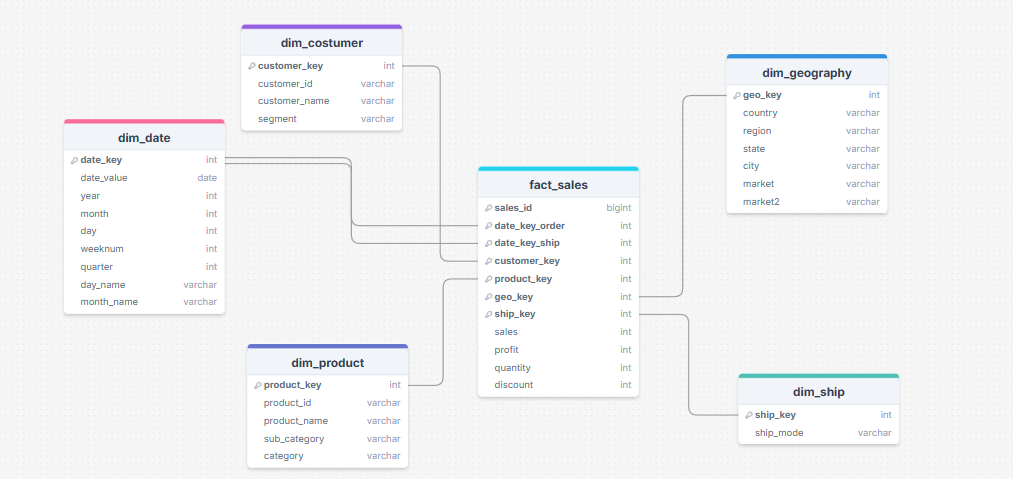

## 10. Criar estrutura da base de dados

## 11. Agendar atualizações de tabelas


**Objetivo:** Projetar um pipeline de atualização de dados.

Para manter os dados atualizados, é necessário definir uma ordem de atualização que respeite as dependências entre as tabelas. O fluxo deve ser o seguinte:

1.  **Atualizar Tabelas de Dimensão:** As tabelas `DimData`, `DimCliente`, `DimProduto`, `DimGeografia` e `DimEnvio` devem ser atualizadas primeiro. Isso garante que todos os novos clientes, produtos ou localidades existam antes de serem referenciados na tabela de fatos.
2.  **Atualizar Tabela de Fatos:** Após a atualização das dimensões, a tabela `FatoVendas` pode ser populada com os novos registros de vendas. As chaves estrangeiras (IDs) serão vinculadas corretamente aos registros recém-adicionados nas tabelas de dimensão.

Este processo garante a integridade referencial do modelo Star Schema.
